In [1]:
import sys
print(sys.executable)  # debe apuntar a .../TFM-Sentidata/.venv/bin/python

# instala en el propio kernel (magia de Jupyter)
%pip install -q --upgrade pip
%pip install -q scikit-learn joblib


/home/judmartz/MASTER_BIGDATA/TFM/TFM-Sentidata/.venv/bin/python
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import sys, joblib, sklearn
print(sys.executable)
print("joblib:", joblib.__version__, "| sklearn:", sklearn.__version__)

/home/judmartz/MASTER_BIGDATA/TFM/TFM-Sentidata/.venv/bin/python
joblib: 1.5.2 | sklearn: 1.7.1


In [2]:
# %% [markdown]
# # 02 · Sentiment mejorado (TF-IDF + LR / Char-ngrams + SVM)
# - Split por producto (si hay `product_id`) o estratificado por clase
# - Muestreo opcional para RAM
# - Modelos: TF-IDF+LogReg y Char-ngrams+LinearSVM
# - Métricas (F1 macro), matriz de confusión, términos top
# - Guardado como Pipeline para servir

# %% Imports y config
import os, re, glob, json, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

RANDOM_STATE = 42
CSV_PATTERN = "../data/exploitation/modelos_input/reviews_base_csv/part-*.csv"
MAX_TRAIN = 300_000   # 0 = sin muestreo

# %% Carga
paths = glob.glob(CSV_PATTERN)
assert paths, f"No se encontró CSV con patrón: {CSV_PATTERN}"
csv_path = paths[0]
df = pd.read_csv(csv_path)
df.columns = [c.lower() for c in df.columns]
df = df.dropna(subset=["review_text","rating"]).copy()
df["rating"] = pd.to_numeric(df["rating"], errors="coerce").clip(1,5)

# Limpieza ligera de texto (conserva negaciones)
df["review_text"] = (df["review_text"].astype(str)
                     .str.replace(r"[\u2028\u2029]", "\n", regex=True)
                     .str.replace("\r","", regex=False)
                     .str.strip()
                     .str.lower())

def rating_to_label(r):
    if r <= 2: return 0
    if r == 3: return 1
    return 2

y = df["rating"].apply(rating_to_label).astype(int).values
X_text = df["review_text"].values

print("Distribución de clases (neg,neu,pos):", np.bincount(y))

Distribución de clases (neg,neu,pos): [114061  81752 899057]


In [3]:
# === Balancear y reducir tamaño ===
import numpy as np

# usa la columna ya limpiada
text_col = "review_text"

# cuántas por clase (ajusta según tu RAM)
PER_CLASS = 80_000   # p.ej. 50_000 si vas justa

rng = np.random.default_rng(42)
idx_sel = []
for c in (0, 1, 2):  # neg, neu, pos
    idx_c = np.flatnonzero(y == c)
    take = min(PER_CLASS, len(idx_c))
    sel = rng.choice(idx_c, size=take, replace=False)
    idx_sel.append(sel)
idx_sel = np.concatenate(idx_sel)

df_bal = df.iloc[idx_sel].reset_index(drop=True)
y_bal  = y[idx_sel]
X_text_bal = df_bal[text_col].astype(str).values

print("Tamaño balanceado:", len(X_text_bal), "| dist:", np.bincount(y_bal))


Tamaño balanceado: 240000 | dist: [80000 80000 80000]


Split (estratificado) sobre el conjunto balanceado

In [4]:
from sklearn.model_selection import train_test_split

# si mantienes product_id y quieres evitar fuga por producto, comenta esto y usa GroupShuffleSplit
X_train_txt, X_test_txt, y_train, y_test = train_test_split(
    X_text_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal
)

len(X_train_txt), len(X_test_txt)


(192000, 48000)

# Modelo 1 (TF-IDF “ligero” + Logistic Regression estable)
Esa celda es el entrenamiento y evaluación de un primer modelo de sentiment analysis.

/home/judmartz/MASTER_BIGDATA/TFM/TFM-Sentidata/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


=== TFIDF + LR ===
              precision    recall  f1-score   support

         neg      0.787     0.792     0.789     16000
         neu      0.716     0.703     0.710     16000
         pos      0.881     0.891     0.886     16000

    accuracy                          0.795     48000
   macro avg      0.794     0.795     0.795     48000
weighted avg      0.794     0.795     0.795     48000

F1 macro: 0.7948479869977255


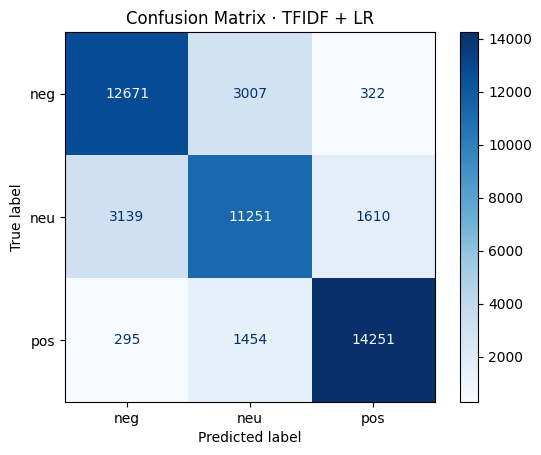

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

pipe_lr = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        min_df=5,                # sube umbral -> menos vocabulario
        max_features=300_000,    # limita dimensión (baja si te falta RAM)
        sublinear_tf=True,
        dtype=np.float32
    )),
    ("clf", LogisticRegression(
        solver="saga",           # más robusto en alta dimensión
        multi_class="ovr",       # reduce memoria frente a multinomial
        class_weight="balanced",
        max_iter=400,
        random_state=42
    ))
])

pipe_lr.fit(X_train_txt, y_train)
pred_lr = pipe_lr.predict(X_test_txt)

print("=== TFIDF + LR ===")
print(classification_report(y_test, pred_lr, target_names=["neg","neu","pos"], digits=3))
print("F1 macro:", f1_score(y_test, pred_lr, average="macro"))

cm = confusion_matrix(y_test, pred_lr, labels=[0,1,2])
ConfusionMatrixDisplay(cm, display_labels=["neg","neu","pos"]).plot(cmap="Blues")
plt.title("Confusion Matrix · TFIDF + LR")
plt.show()


In [2]:
# -- Bootstrap rápido para tener X_train_txt, X_test_txt, y_train, y_test --
import glob, re, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split

CSV_PATTERN = "../data/exploitation/modelos_input/reviews_base_csv/part-*.csv"
csv_path = sorted(glob.glob(CSV_PATTERN))[0]

df = pd.read_csv(csv_path)
df.columns = [c.lower() for c in df.columns]
df = df.dropna(subset=["review_text","rating"]).copy()
df["rating"] = pd.to_numeric(df["rating"], errors="coerce").clip(1,5)
df["review_text"] = (df["review_text"].astype(str)
                     .str.replace(r"[\u2028\u2029]", "\n", regex=True)
                     .str.replace("\r", "", regex=False)
                     .str.strip().str.lower())

def rating_to_label(r): r=float(r); return 0 if r<=2 else (1 if r==3 else 2)
y = df["rating"].apply(rating_to_label).astype(int).values

# Balanceo (ajusta PER_CLASS si te falta RAM)
PER_CLASS = 80_000
rng = np.random.default_rng(42)
idx_sel = np.concatenate([
    rng.choice(np.flatnonzero(y==c), size=min(PER_CLASS, (y==c).sum()), replace=False)
    for c in (0,1,2)
])
df_bal = df.iloc[idx_sel].reset_index(drop=True)
y_bal  = y[idx_sel]

X_train_txt, X_test_txt, y_train, y_test = train_test_split(
    df_bal["review_text"].values, y_bal, test_size=0.2, random_state=42, stratify=y_bal
)

print("Listo:", len(X_train_txt), len(X_test_txt), np.bincount(y_train))


Listo: 192000 48000 [64000 64000 64000]


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Configuración segura para 4 GB RAM
pipe_svm_char = Pipeline([
    ("tfidf", TfidfVectorizer(
        analyzer="char_wb",
        ngram_range=(3,3),      # solo trigramas (reduce memoria)
        min_df=30,              # descarta términos poco frecuentes
        max_features=50_000,    # límite bajo de vocabulario
        dtype=np.float32
    )),
    ("clf", LinearSVC(
        C=1.0,
        class_weight="balanced",
        random_state=42
    ))
])

# Entrenamiento
pipe_svm_char.fit(X_train_txt, y_train)

# Predicción
pred_svm = pipe_svm_char.predict(X_test_txt)

# Reporte de métricas
print("=== Char n-grams + LinearSVC (ajustado a 4GB RAM) ===")
print(classification_report(y_test, pred_svm, target_names=["neg","neu","pos"], digits=3))
print("F1 macro:", f1_score(y_test, pred_svm, average="macro"))

# Matriz de confusión
cm2 = confusion_matrix(y_test, pred_svm, labels=[0,1,2])




=== Char n-grams + LinearSVC (ajustado a 4GB RAM) ===
              precision    recall  f1-score   support

         neg      0.737     0.748     0.743     16000
         neu      0.672     0.646     0.659     16000
         pos      0.832     0.852     0.842     16000

    accuracy                          0.749     48000
   macro avg      0.747     0.749     0.748     48000
weighted avg      0.747     0.749     0.748     48000

F1 macro: 0.7476661710337978


In [4]:
# %% Guardar el mejor como Pipeline
os.makedirs("../models/sentiment_v1", exist_ok=True)

# elige el mejor por F1 macro
f1_lr  = f1_score(y_test, pred_lr,  average="macro")
f1_svm = f1_score(y_test, pred_svm, average="macro")
best_name, best_pipe, best_f1 = ("tfidf_lr", pipe_lr, f1_lr) if f1_lr >= f1_svm else ("char_svm", pipe_svm_char, f1_svm)

joblib.dump(best_pipe, f"../models/sentiment_v1/{best_name}.joblib")
with open("../models/sentiment_v1/metrics.json","w") as f:
    json.dump({"f1_macro": float(best_f1), "model": best_name}, f, indent=2)
print(f"Guardado ../models/sentiment_v1/{best_name}.joblib | F1 macro={best_f1:.3f}")

# %% Interpretabilidad rápida (solo si el mejor es TF-IDF+LR)
if best_name == "tfidf_lr":
    vec: TfidfVectorizer = best_pipe.named_steps["tfidf"]
    clf: LogisticRegression = best_pipe.named_steps["clf"]
    feature_names = np.array(vec.get_feature_names_out())
    coef = clf.coef_
    for label, name in zip([0,1,2], ["negativo","neutro","positivo"]):
        top = np.argsort(coef[label])[-20:][::-1]
        print(f"\nTop n-gramas → {name}:")
        print(", ".join(feature_names[top]))
else:
    print("Interpretabilidad por coeficientes no disponible para SVM char (usa LIME/SHAP si quieres).")

NameError: name 'os' is not defined